In [1]:
%load_ext autoreload
%autoreload 2

import os
import json

from datetime import datetime
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import collections
import time
import scipy
import functools
import pickle


import sklearn
import sklearn.preprocessing
from sklearn.utils import shuffle


plt.figure(num=None, figsize=(28, 28), dpi=80, facecolor='w', edgecolor='k')


%matplotlib inline

In [2]:
D = 12 # number of dimensions
N = 1000 # number of pieces of equipment
T = 100 # number of timestamps

SAVE = False

In [3]:
np.random.seed(23)

In [4]:
# survival curves S(t) = exp(-\lambda t)
# can be used Weibull, Gompertz-Makeham,

def S(lmbd, t):
    return np.exp(-lmbd * t)

<AxesSubplot:title={'center':'S'}>

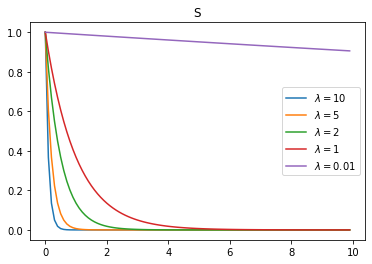

In [5]:
xs = np.arange(0, 10, 0.1)
plt.title("S")
sns.lineplot(x=xs, y=S(10, xs), label=r"$\lambda=10$")
sns.lineplot(x=xs, y=S(5, xs), label=r"$\lambda=5$")
sns.lineplot(x=xs, y=S(2, xs), label=r"$\lambda=2$")
sns.lineplot(x=xs, y=S(1, xs), label=r"$\lambda=1$")
sns.lineplot(x=xs, y=S(0.01, xs), label=r"$\lambda=0.01$")

## Workstation parameters
- $\lambda$, survival curve parameter,
- $\rho$ recover curve parameter (more rho, slower the recovery), 
- $P_1^D$ parameterized distributions for all features, one of the parameters is $S(\lambda, t)$,

In [6]:
def R(rho, lmbd, t):
    s_ = S(lmbd, t)
    return (1 - s_) - rho

<AxesSubplot:title={'center':'R'}>

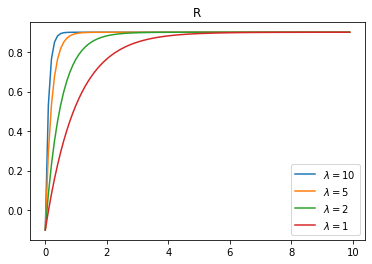

In [7]:
xs = np.arange(0, 10, 0.1)
plt.title("R")
sns.lineplot(x=xs, y=R(0.1, 10, xs), label=r"$\lambda=10$")
sns.lineplot(x=xs, y=R(0.1, 5, xs), label=r"$\lambda=5$")
sns.lineplot(x=xs, y=R(0.1, 2, xs), label=r"$\lambda=2$")
sns.lineplot(x=xs, y=R(0.1, 1, xs), label=r"$\lambda=1$")

In [8]:
from tqdm import tqdm
CAT_FEATURES = [0, 1, 2, 3, 4, 5, 6, 7]

encoders = {d: sklearn.preprocessing.OneHotEncoder() for d in CAT_FEATURES}
for d in CAT_FEATURES:
    encoders[d].fit([[d],[d+2], [d+4], [d+1], [d+3], [d+5], [d+7]])
    
    
def mixture_function(a, x):
    return (a**x - 1) / (a - 1)
    
    
switches = {d: np.random.gamma(4, 2) for d in range(D)}
m_norms = {d: lambda: np.random.gamma(2, 1) for d in range(D)}
sigma_norms = {d: lambda: np.random.gamma(1, 1) for d in range(D)}


def sample_equipment(N, D, T):
    equipment = []
    dataset = []
    for i in tqdm(range(N)):
        last_norm_tmp = 0
        lmbd = np.random.gamma(1, 0.005) # 0.005
        rho = np.random.gamma(1, 0.1)
        equipment.append({"lambda": lmbd, "rho": rho})
        current_measurements = []
        ss = []
        fix_tmps = []
        rnd = np.random.uniform(0, 1)
        for t in range(T):
            measurements = []

            s_ = S(lmbd, t - last_norm_tmp)
            r_ = R(rho, lmbd, t - last_norm_tmp)
            ss.append(s_)
            
            if rnd < r_:
                rnd = np.random.uniform(0, 1)
                last_norm_tmp = t
                fix_tmps.append(t)
            
            for d in range(D):
                m_norm = m_norms[d]()
                sigma_norm = sigma_norms[d]()
            
                m_abnorm = m_norm + switches[d]
                sigma_abnorm = 1.5 * sigma_norm
                
                if d in CAT_FEATURES:
                    norm_functioning = np.random.choice([d, d+2, d+4], p=[0.7, 0.2, 0.1])
                    abnorm_functioning = np.random.choice([d+1, d+3, d+5, d+7], p=[0.2, 0.2, 0.4, 0.2])
                else:                
                    norm_functioning = np.random.normal(m_norm, sigma_norm)
                    abnorm_functioning = np.random.normal(m_abnorm, sigma_abnorm)
                
                mixt = mixture_function(3, s_)
                if d in CAT_FEATURES:
                    if rnd < 1 - s_:
                        measurements.extend(encoders[d].transform([[abnorm_functioning]]).toarray()[0])
                    else:
                        measurements.extend(encoders[d].transform([[norm_functioning]]).toarray()[0])
                else:
                    measurements.extend([mixt * norm_functioning + (1 - mixt) * abnorm_functioning])

            if not len(current_measurements):
                current_measurements.append([measurements])
                current_measurements = np.array(current_measurements[0])
            else:
                current_measurements = np.concatenate((current_measurements, np.array(measurements)[np.newaxis, :]), axis=0)
        equipment[-1]["fixes"] = fix_tmps
        equipment[-1]["ss"] = ss
        dataset.append(current_measurements)
    dataset = np.transpose(np.array(dataset), [0, 2, 1])
    return dataset, equipment

dataset, equipment = sample_equipment(N, D, T)

100%|██████████| 1000/1000 [10:40<00:00,  1.56it/s]


In [9]:
encoders[1].transform([[1]]).toarray()[0]

array([1., 0., 0., 0., 0., 0., 0.])

In [10]:
dataset.shape

(1000, 60, 100)

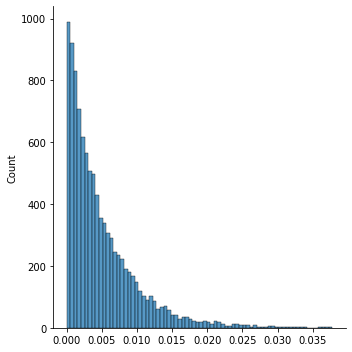

In [11]:
sns.displot(np.random.gamma(1, 0.005, 10000))

In [12]:
np.median(np.random.gamma(4, 2, 10000))

7.336412125861795

### Save 

In [13]:
if SAVE:
    pickle.dump(dataset, open("../data/dataset.pkl", "wb"))
    pickle.dump(equipment, open("../data/equipment.pkl", "wb"))